# Dataset Creation (Part 2)

Continuing from part 1, we follow an existing paper pipeline to select usable load signature per appliance.

While in the final study, the created per-appliance load signature library is not used. This can be useful in future studies where we explore load masking through generating artificial load pattern that mimicks per-appliance load signature.

After creating our master dataframe with appliance's load aligned to the main smart meter load.

## Instruction

Just run the cells at once

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime, timedelta, timezone

In [2]:
# read the master dataframe

dataset_folder = Path('dataset', datetime(2025, 7, 7).strftime('%Y%m%d'))
aggregate_df = pd.read_pickle(dataset_folder / 'aggregate_df.pkl')

date_segments = []

with open(dataset_folder / 'date_segments.txt', 'r') as f:
    for line in f:
        start_str, end_str = line.strip().split(' - ')
        start = datetime.fromisoformat(start_str)
        end = datetime.fromisoformat(end_str)
        date_segments.append((start, end))

In [3]:
aggregate_df

,timestamp,aggregate,datetime,washing_machine,dishwasher,fridge,kettle,microwave,toaster,tv,htpc,gas_oven,kitchen_lights
0,1.356998e+09,499.0,2013-01-01 00:00:01+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
1,1.356998e+09,500.0,2013-01-01 00:00:07+00:00,0.0,1.0,89.0,1.0,1.0,0.0,89.0,69.0,NaN,0.0
2,1.356998e+09,515.0,2013-01-01 00:00:13+00:00,0.0,1.0,88.0,1.0,1.0,0.0,125.0,70.0,NaN,0.0
3,1.356998e+09,522.0,2013-01-01 00:00:19+00:00,0.0,1.0,89.0,1.0,1.0,0.0,91.0,70.0,NaN,0.0
4,1.356998e+09,508.0,2013-01-01 00:00:26+00:00,0.0,1.0,89.0,1.0,1.0,0.0,93.0,69.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341544,1.388448e+09,178.0,2013-12-30 23:59:35+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341545,1.388448e+09,177.0,2013-12-30 23:59:41+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341546,1.388448e+09,178.0,2013-12-30 23:59:47+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4341547,1.388448e+09,178.0,2013-12-30 23:59:53+00:00,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0


---

In [4]:
# window_length = 24 * 60 * (60 / 6)
window_length = 100     # following the original paper, this is the window length for the algorithm

x_threshold = 20
# window length consists of a whole day of data, with sample rate of 1/6 Hz
x_noise = 0.1 * x_threshold     # assume
x_clip = 2500

def data_cleaning_and_selection_per_appliance(df, x_threshold, x_noise, x_clip, window_length):
    """
    Clean and select data for each appliance.
    Modified from paper: Zeyi Geng, Linfeng Yang, Wuqing Yu,
    A diffusion model-based framework to enhance the robustness of non-intrusive load disaggregation,
    DOI: https://doi.org/10.1016/j.energy.2025.135423.
    
    Parameters:
    - df: dataframe containing the load data of the appliance
    - x_threshold: on-power threshold
    - x_noise: noise threshold
    - window_length: length of the window in seconds
    
    Returns:
    - cleaned_data: dict of cleaned DataFrames 
    """
    
    appliance_name = df.columns[1]  # assuming the first column is the timestamp, and the second column is the appliance data
    print(f"Processing appliance: {appliance_name}")

    selected_range = []

    # set load smaller than x_noise to 0
    df[appliance_name] = df[appliance_name].apply(lambda x: x if x >= x_noise else 0)

    # set load larger than x_clip to x_clip
    df[appliance_name] = df[appliance_name].apply(lambda x: x if x <= x_clip else x_clip)

    start_indices = df.index[df[appliance_name] >= x_threshold].tolist()
    if not start_indices:
        print(f"No data points above noise threshold for {appliance_name}.")
        return selected_range, None

    for index in start_indices:
        _start = int(max(0, index - window_length))
        _end = int(min(len(df), index + window_length + 1))

        selected_range.append((_start, _end))

    # given the selected ranges, visit each range and construct non-overlapping ranges
    selected_range_v2 = []
    cleaned_data = []
    i = 0
    while i < len(selected_range):
        start, end = selected_range[i]
        # If the next range overlaps with the current one, merge them
        while i + 1 < len(selected_range) and selected_range[i + 1][0] < end:
            end = max(end, selected_range[i + 1][1])
            i += 1

        selected_range_v2.append((start, end))
        i += 1

    # Now we have non-overlapping ranges, we can extract the data
    for start, end in selected_range_v2:
        cleaned_data.append(df.iloc[start:end])

    # Concatenate all cleaned data into a single DataFrame
    cleaned_df = pd.concat(cleaned_data, axis=0)
    cleaned_df.reset_index(inplace=True)

    return selected_range_v2, cleaned_df


---

Build each appliance's df from the aggregate_df

In [5]:
data = {}

for appliance in aggregate_df.columns[3:]:
    df = aggregate_df[['timestamp', appliance]].copy()
    data[appliance] = df

In [6]:
data['dishwasher']

,timestamp,dishwasher
0,1.356998e+09,1.0
1,1.356998e+09,1.0
2,1.356998e+09,1.0
3,1.356998e+09,1.0
4,1.356998e+09,1.0
...,...,...
4341544,1.388448e+09,1.0
4341545,1.388448e+09,1.0
4341546,1.388448e+09,1.0
4341547,1.388448e+09,1.0


Note that the data clipping is not applied to the master aggregate_df.

However, it is applied to each appliance to reduce noise -> smoother generation of the masked load from samples

In [7]:
import pandas as pd

# Define constants for each appliance (example values, update as needed)
appliance_constants_dict = {
    'washing_machine': {'on_power_threshold': 20, 'noise_threshold': 5, 'clipping_threshold': 2500},
    'dishwasher': {'on_power_threshold': 10, 'noise_threshold': 5, 'clipping_threshold': 2500},
    'fridge': {'on_power_threshold': 50, 'noise_threshold': 18, 'clipping_threshold': 350},
    'kettle': {'on_power_threshold': 200, 'noise_threshold': 30, 'clipping_threshold': 3100},
    'microwave': {'on_power_threshold': 200, 'noise_threshold': 30, 'clipping_threshold': 3000},
    'toaster': {'on_power_threshold': 150, 'noise_threshold': 15, 'clipping_threshold': 3000},
    'tv': {'on_power_threshold': 70, 'noise_threshold': 12, 'clipping_threshold': 250},
    'htpc': {'on_power_threshold': 50, 'noise_threshold': 10, 'clipping_threshold': 400},
    # 'kitchen_radio': {'on_power_threshold': 15, 'noise_threshold': 10, 'clipping_threshold': 200},
    'gas_oven': {'on_power_threshold': 50, 'noise_threshold': 5, 'clipping_threshold': 1000},
    'kitchen_lights': {'on_power_threshold': 60, 'noise_threshold': 10, 'clipping_threshold': 430},
}

appliances_constants = pd.DataFrame.from_dict(appliance_constants_dict, orient='index')
appliances_constants

,on_power_threshold,noise_threshold,clipping_threshold
washing_machine,20,5,2500
dishwasher,10,5,2500
fridge,50,18,350
kettle,200,30,3100
microwave,200,30,3000
toaster,150,15,3000
tv,70,12,250
htpc,50,10,400
gas_oven,50,5,1000
kitchen_lights,60,10,430


In [8]:
selected_range_dict = {}
cleaned_data_dict = {}

for appliance, df in data.items():  # Skip 'aggregate' as it is not an appliance
    if appliance in data:
        selected_range, cleaned_data = data_cleaning_and_selection_per_appliance(df,
                                                                                 appliance_constants_dict[appliance]['on_power_threshold'], 
                                                                                 appliance_constants_dict[appliance]['noise_threshold'],
                                                                                 appliance_constants_dict[appliance]['clipping_threshold'],
                                                                                 window_length)
        selected_range_dict[appliance] = selected_range
        cleaned_data_dict[appliance] = cleaned_data
    else:
        print(f"Data for {appliance} not found.")

Processing appliance: washing_machine
Processing appliance: dishwasher
Processing appliance: fridge
Processing appliance: kettle
Processing appliance: microwave
Processing appliance: toaster
Processing appliance: tv
Processing appliance: htpc
Processing appliance: gas_oven
Processing appliance: kitchen_lights


Selected range for tv: (7207, 8194)


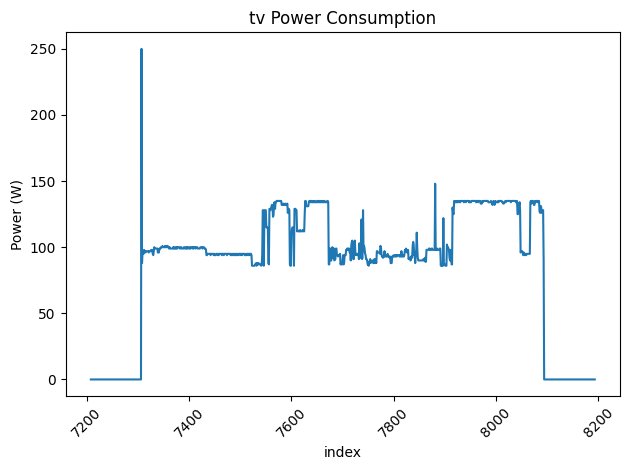

In [9]:
# plot the dataframe using seaborn

appliance_name = 'tv'  # Change this to the appliance you want to plot
idx = 1

appliance_df = cleaned_data_dict[appliance_name]
selected_range = selected_range_dict[appliance_name]

print(f"Selected range for {appliance_name}: {selected_range[idx]}")

data_df = appliance_df[(selected_range[idx][0] < appliance_df['index']) & (appliance_df['index'] < selected_range[idx][1])]
sns.lineplot(data=data_df, x='index', y=f'{appliance_name}')
plt.xticks(rotation=45)
plt.xlabel('index')
plt.ylabel('Power (W)')
plt.title(f'{appliance_name} Power Consumption')
plt.tight_layout()
plt.show()

Create folder and save each appliance's load signature set

In [10]:
load_signature_folder = dataset_folder / 'load_signature_library'
load_signature_folder.mkdir(parents=True)

# save a dataframe for each appliance, together with the selected ranges
for appliance, df in cleaned_data_dict.items():
    per_appl_folder = load_signature_folder / appliance
    per_appl_folder.mkdir(parents=True)

    df.to_pickle(per_appl_folder / 'load_signatures.pkl')
    with open(per_appl_folder / 'selected_ranges.txt', 'w') as f:
        for start, end in selected_range_dict[appliance]:
            f.write(f"{start},{end}\n")

    print(f"Saved load signatures for {appliance} in {per_appl_folder}")


Saved load signatures for washing_machine in dataset/20250707/load_signature_library/washing_machine
Saved load signatures for dishwasher in dataset/20250707/load_signature_library/dishwasher
Saved load signatures for fridge in dataset/20250707/load_signature_library/fridge
Saved load signatures for kettle in dataset/20250707/load_signature_library/kettle
Saved load signatures for microwave in dataset/20250707/load_signature_library/microwave
Saved load signatures for toaster in dataset/20250707/load_signature_library/toaster
Saved load signatures for tv in dataset/20250707/load_signature_library/tv
Saved load signatures for htpc in dataset/20250707/load_signature_library/htpc
Saved load signatures for gas_oven in dataset/20250707/load_signature_library/gas_oven
Saved load signatures for kitchen_lights in dataset/20250707/load_signature_library/kitchen_lights
